## Архитектуры свёрточных сетей

In [1]:
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [7]:
def train(net, train_iter, test_iter, trainer, num_epochs, name):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            if name == 'inception_v3':
                y_hat, _ = net(X)
            else:
                y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
            # очистить кэш
            torch.cuda.empty_cache()
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## DataSet

In [12]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', 'digits', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', 'digits', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [14]:
# Классы в наборе данных
print(*train_dataset.classes)

0 1 2 3 4 5 6 7 8 9


In [16]:
# Баланс классов
def classBalance(ds, title):
    cBalance = torch.zeros(len(ds.classes))
    i = 0
    for X, y in ds:
        cBalance[y] += 1
    print('Размер набора данных: ', len(ds))
    plt.bar(torch.arange(len(ds.classes)), cBalance)
    plt.title(title)
    plt.show()

Размер набора данных:  40000


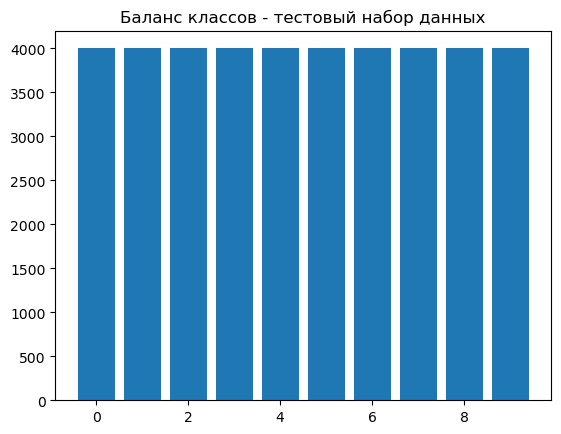

In [18]:
classBalance(test_dataset, 'Баланс классов - тестовый набор данных')

Размер набора данных:  240000


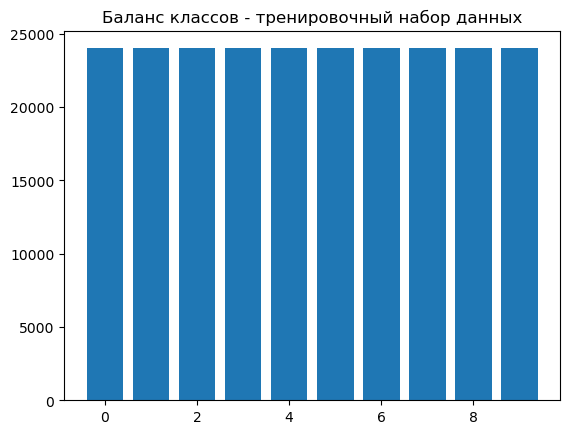

In [19]:
classBalance(train_dataset, 'Баланс классов - тренировочный набор данных')

In [18]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

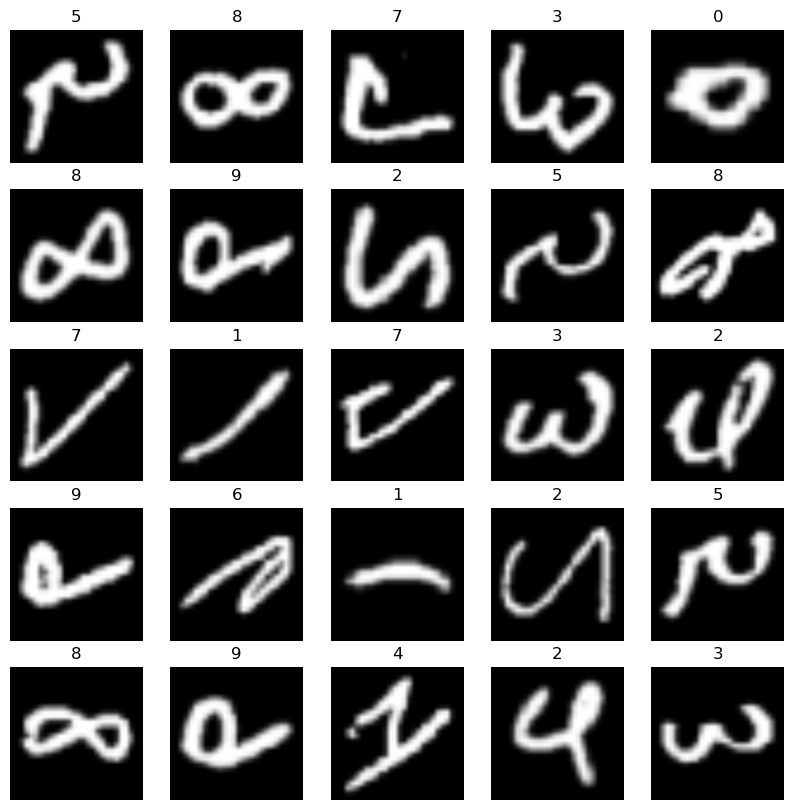

In [20]:
# Примеры из тренировочного набора
LABELS = torch.arange(len(train_dataset.classes))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    plt.imshow(img[0].numpy(), cmap='gray');
    plt.title(LABELS[label].item())
    plt.axis('off')

In [22]:
#plt.imshow(train_dataset[0][0][0].numpy().reshape(224,224), cmap='gray');

## Предобученные архитектуры

In [17]:
# transoforms = tv.transforms.Compose([
#     tv.transforms.Grayscale(3),
#     tv.transforms.Resize((224, 224)),
#     tv.transforms.ToTensor()
# ])

# train_dataset = tv.datasets.MNIST('.', train=True, transform=transoforms, download=True)
# test_dataset = tv.datasets.MNIST('.', train=False, transform=transoforms, download=True)
# train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
# test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [18]:
# train_dataset[0][0].shape

#### ResNet

In [20]:
model = tv.models.resnet18(weights='DEFAULT')

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [23]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [24]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [25]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [26]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [27]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [28]:
train(model, train_iter, test_iter, trainer, 1, name='resnet18')

Step 0. time since epoch: 0.327. Train acc: 0.133. Train Loss: 2.320
Step 100. time since epoch: 29.639. Train acc: 0.797. Train Loss: 0.917
Step 200. time since epoch: 58.899. Train acc: 0.863. Train Loss: 0.636
Step 300. time since epoch: 88.243. Train acc: 0.889. Train Loss: 0.512
Step 400. time since epoch: 117.736. Train acc: 0.905. Train Loss: 0.437
Step 500. time since epoch: 147.099. Train acc: 0.914. Train Loss: 0.388
Step 600. time since epoch: 176.565. Train acc: 0.922. Train Loss: 0.351
Step 700. time since epoch: 206.159. Train acc: 0.927. Train Loss: 0.323
Step 800. time since epoch: 235.614. Train acc: 0.932. Train Loss: 0.301
Step 900. time since epoch: 265.712. Train acc: 0.935. Train Loss: 0.284
--------------------
epoch 1, loss 0.2780, train acc 0.936, test acc 0.966, time 302.1 sec


#### DenseNet

In [30]:
model = tv.models.densenet161(weights='DEFAULT')

In [31]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [32]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [33]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [34]:
model.classifier = nn.Linear(in_features=2208, out_features=10)

In [35]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [36]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [37]:
train(model, train_iter, test_iter, trainer, 1, name='densenet161')

Step 0. time since epoch: 1.246. Train acc: 0.105. Train Loss: 2.346
Step 100. time since epoch: 125.551. Train acc: 0.813. Train Loss: 0.857
Step 200. time since epoch: 249.738. Train acc: 0.869. Train Loss: 0.602
Step 300. time since epoch: 374.012. Train acc: 0.893. Train Loss: 0.487
Step 400. time since epoch: 498.242. Train acc: 0.907. Train Loss: 0.418
Step 500. time since epoch: 622.342. Train acc: 0.916. Train Loss: 0.372
Step 600. time since epoch: 746.495. Train acc: 0.923. Train Loss: 0.338
Step 700. time since epoch: 870.645. Train acc: 0.929. Train Loss: 0.311
Step 800. time since epoch: 994.766. Train acc: 0.933. Train Loss: 0.290
Step 900. time since epoch: 1118.962. Train acc: 0.936. Train Loss: 0.273
--------------------
epoch 1, loss 0.2676, train acc 0.937, test acc 0.968, time 1321.6 sec


#### VGG 16

In [39]:
model = tv.models.vgg16(weights=True)

/home/a.stolbov@reph.ru/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
#summary(model.to(device), input_size=(3, 224, 224))
summary(model.to('cuda'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [42]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [43]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [44]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
# model.classifier = nn.Sequential(
#     nn.Linear(in_features=25088, out_features=4096, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=4096, out_features=4096, bias=True),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5, inplace=False),
#     nn.Linear(in_features=4096, out_features=10, bias=True)
# )

In [45]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

In [46]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [47]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [48]:
train(model, train_iter, test_iter, trainer, 1, name='vgg16')

Step 0. time since epoch: 1.138. Train acc: 0.043. Train Loss: 2.389
Step 100. time since epoch: 109.387. Train acc: 0.765. Train Loss: 0.839
Step 200. time since epoch: 217.316. Train acc: 0.816. Train Loss: 0.647
Step 300. time since epoch: 325.649. Train acc: 0.838. Train Loss: 0.561
Step 400. time since epoch: 434.219. Train acc: 0.852. Train Loss: 0.508
Step 500. time since epoch: 542.812. Train acc: 0.860. Train Loss: 0.475
Step 600. time since epoch: 651.695. Train acc: 0.867. Train Loss: 0.449
Step 700. time since epoch: 760.336. Train acc: 0.872. Train Loss: 0.429
Step 800. time since epoch: 868.992. Train acc: 0.877. Train Loss: 0.412
Step 900. time since epoch: 977.553. Train acc: 0.880. Train Loss: 0.400
--------------------
epoch 1, loss 0.3956, train acc 0.881, test acc 0.953, time 1153.9 sec


#### Inception v3

##### DataSet

In [24]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', 'digits', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', 'digits', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [26]:
train_dataset[0][0].shape

torch.Size([3, 299, 299])

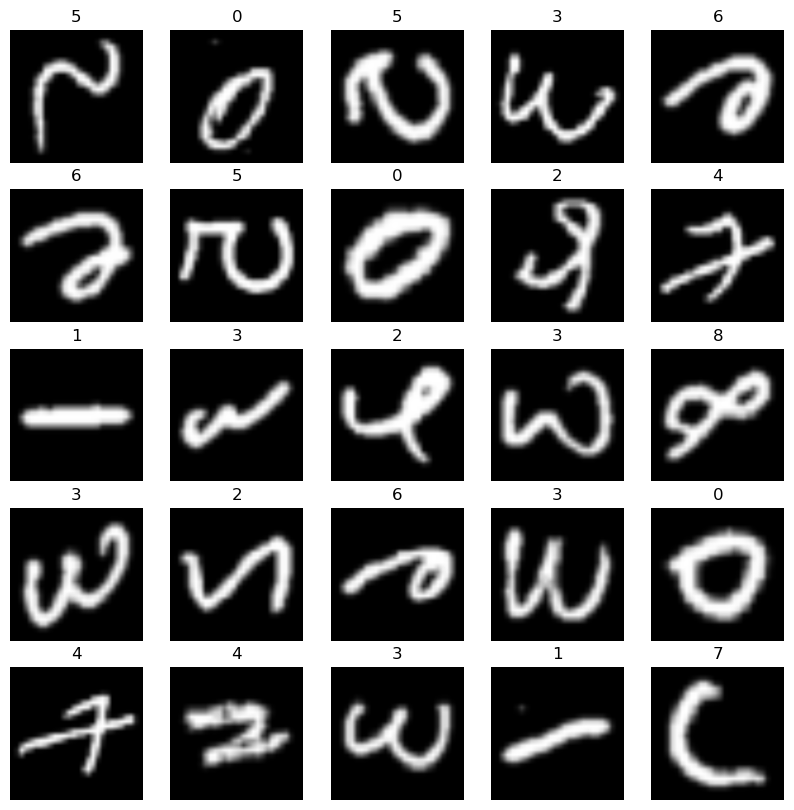

In [30]:
# Примеры из тренировочного набора
LABELS = torch.arange(len(train_dataset.classes))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    plt.imshow(img[0].numpy(), cmap='gray');
    plt.title(LABELS[label].item())
    plt.axis('off')

In [32]:
model = tv.models.inception_v3(weights='DEFAULT')

In [34]:
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [36]:
summary(model.to('cuda'), input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [38]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [40]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [42]:
model.fc = nn.Linear(in_features=2048, out_features=10)

In [44]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [46]:
#summary(model.to('cuda'), input_size=(3, 299, 299))

In [48]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [50]:
train(model, train_iter, test_iter, trainer, 1, name='inception_v3')

Step 0. time since epoch: 0.847. Train acc: 0.133. Train Loss: 2.344
Step 100. time since epoch: 82.285. Train acc: 0.688. Train Loss: 1.201
Step 200. time since epoch: 163.272. Train acc: 0.752. Train Loss: 0.936
Step 300. time since epoch: 243.324. Train acc: 0.781. Train Loss: 0.809
Step 400. time since epoch: 323.428. Train acc: 0.798. Train Loss: 0.733
Step 500. time since epoch: 403.552. Train acc: 0.808. Train Loss: 0.683
Step 600. time since epoch: 483.681. Train acc: 0.817. Train Loss: 0.643
Step 700. time since epoch: 563.955. Train acc: 0.824. Train Loss: 0.613
Step 800. time since epoch: 644.169. Train acc: 0.829. Train Loss: 0.589
Step 900. time since epoch: 724.405. Train acc: 0.833. Train Loss: 0.570
--------------------
epoch 1, loss 0.5644, train acc 0.834, test acc 0.916, time 839.0 sec
